In [55]:
import geopandas as gpd 
import numpy as np 
import os
import matplotlib.pyplot as plt 
import rasterio as rio 
import rioxarray as rioxr
import pandas as pd
import xarray as xr
import pandas
import pickle
import seaborn as sns
from typing import List, Dict, Any, Tuple
import pprint as pp

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score, precision_score, f1_score

In [4]:
class Cfg: 
    size_test=0.3
    seed=12

In [5]:
project_dir = "/home/rustt/Documents/Projects/S1_S2_classification"
data_dir = os.path.join(project_dir, "sentinel_classification/data/processed")
model_dir = os.path.join(project_dir, "sentinel_classification/models")
out_dir = os.path.join(project_dir, "sentinel_classification/data/final")

In [67]:
#s2_stack_path = os.path.join(data_dir, "s2", "clip_s2_pan_sharp.tif")
s2_arr = np.load(os.path.join(out_dir, "s2_stack.npy"))
labels =  np.load(os.path.join(out_dir, "labels.npy"))
labels_df = gpd.read_file(os.path.join(data_dir, "ROI_Classif_corrected.shp"))

In [7]:
s2_arr.shape

(442316, 10)

### Utils

In [191]:
def remove_px_class(X: np.ndarray, y: np.ndarray, px_cls: List[int]) -> Tuple[np.ndarray, np.ndarray]: 
    """
    Remove pixels associated to input px_cls
    """
    df = pd.concat([pd.DataFrame(X, columns=[str(i) for i in range(X.shape[1])]), pd.Series(y, name="y")], axis=1)
    df = df[~df.y.isin(px_cls)]
    X = df.drop("y", axis=1).values 
    y = df.y.values 
    return X, y

In [192]:
def load_input(stack_path: str, labels_path:str) -> Tuple[np.ndarray, np.ndarray]:
    """
    load modelisation input
    """
    X = np.load(stack_path)
    y =  np.load(os.path.join(out_dir, "labels.npy"))
    return X, y

#### Resample : Filter on min sample

In [103]:
def resample_cls(X, y, seed=12):
    """
    resample based on min class
    """
    
    np.random.seed(seed)
    min_sample = np.min(pd.Series(y).value_counts())
        
    y_df = pd.Series(y)
    y_indices_resample = []
    for label in y_df.unique():
        y_label = np.random.choice(np.where(y_df == label)[0], min_sample, replace=False).tolist()
        y_indices_resample.extend(y_label)
    
    y_resample = y[y_indices_resample]
    X_resample = X[y_indices_resample, :]

    return X_resample, y_resample

In [133]:
def get_modelisation_input(stack_path: str, 
                           labels_path:str, 
                           rm_px_cls: List[int]=None,
                           resample:bool=True,
                           cfg:Any=Cfg) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    get modelisation input
    - load 
    - process : select & resample classes
    - split train / test sets
    """
    
    X, y = load_input(stack_path, labels_path)

    if rm_px_cls:
        X, y = remove_px_class(X, y, px_cls=rm_px_cls)
    if resample:
        X, y = resample_cls(X, y, cfg.seed)

    # convert DN to reflectance
    X = X / 10000

    # encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=cfg.size_test, 
        stratify=y, 
        random_state=cfg.seed
    )


    return X_train, X_test, y_train, y_test, label_encoder

### Labels names

In [22]:
with open(os.path.join(data_dir, "band_mapping_stack.pkl"), "rb") as fp: 
    band_mapping = pickle.load(fp)

In [430]:
labels_mapping = labels_df.groupby("classid")["classlabel"].first().to_dict()

In [442]:
# write labels mapping
with open(os.path.join(data_dir, "labels_mapping.pkl"), "wb") as fp: 
    pickle.dump(labels_mapping, fp)

In [68]:
# read labels mapping
with open(os.path.join(data_dir, "labels_mapping.pkl"), "rb") as fp: 
    labels_mapping = pickle.load(fp)

In [69]:
labels_mapping

{1: '1 - coastal mangrove',
 2: '2 - forest',
 3: '3 - swamps',
 4: '4 - herbaceous savana',
 5: '5 - bare soil',
 6: '6 - water',
 7: '7 - building area',
 11: '11 - low mangrove',
 12: '12 - high mangrove',
 13: '13 - clouds'}

### Modelisation input

In [193]:
X_train_s2, X_test_s2, y_train_s2, y_test_s2, label_encoder_s2 = get_modelisation_input(
    stack_path=os.path.join(out_dir, "s2_stack.npy"), 
    labels_path=os.path.join(out_dir, "labels.npy"), 
    rm_px_cls=None,
    resample=True,
    cfg=Cfg,
)

In [202]:
X_train_s1, X_test_s1, y_train_s1, y_test_s1, label_encoder_s1 = get_modelisation_input(
    stack_path=os.path.join(out_dir, "s1_stack.npy"), 
    labels_path=os.path.join(out_dir, "labels.npy"), 
    rm_px_cls=[13], # remove cloud class
    resample=True,
    cfg=Cfg,
)

In [195]:
X_train_s1s2, X_test_s1s2, y_train_s1s2, y_test_s1s2, label_encoder_s1s2 = get_modelisation_input(
    stack_path=os.path.join(out_dir, "s1s2_stack.npy"), 
    labels_path=os.path.join(out_dir, "labels.npy"), 
    rm_px_cls=[13], # remove clouds
    resample=True,
    cfg=Cfg,
)

In [116]:
print("--- train ---")
print(X_train_s2.shape)
print(y_train_s2.shape)
print("--- test ---")
print(X_test_s2.shape)
print(y_test_s2.shape)

--- train ---
(84763, 10)
(84763,)
--- test ---
(36327, 10)
(36327,)


### Models

In [213]:
%%time
rf = RandomForestClassifier(n_jobs=-1, random_state=Cfg.seed)

CPU times: user 70 µs, sys: 2 µs, total: 72 µs
Wall time: 85.6 µs


In [214]:
%%time
knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)

CPU times: user 45 µs, sys: 1e+03 ns, total: 46 µs
Wall time: 55.8 µs


In [215]:
%%time
pipe_lr = make_pipeline(
    StandardScaler(), 
    OneVsRestClassifier(LogisticRegression(multi_class="ovr", 
                                           random_state=Cfg.seed), 
                        n_jobs=-1)
)

CPU times: user 101 µs, sys: 2 µs, total: 103 µs
Wall time: 112 µs


https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier

### Evaluation

In [196]:
def get_metrics(y_test, y_pred, target_names=None): 

    if target_names is None: 
        target_names = [i for i in np.unique(y_test)]
    else:
        target_names = [target_names[i] for i in np.unique(y_test)]
    
    acc = accuracy_score(y_test, y_pred)
    kp  = cohen_kappa_score(y_test, y_pred)
    
    # mean of metrics (unweighted)
    precision = precision_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")

    # metrics by class
    precision_cls = dict(zip(target_names, precision_score(y_test, y_pred, average=None)))
    f1_cls = dict(zip(target_names, f1_score(y_test, y_pred, average=None)))

    metrics = {
        "accuracy":acc,
        "kappa_score":kp,
        "avg_precision":precision,
        "avg_f1score": f1,
        "precision_cls":precision_cls,
        "f1_cls":f1_cls,
    }

    pp.pprint(metrics)

In [197]:
def predict(clf, X):
    y_pred = clf.predict(X)
    return y_pred

In [217]:
def get_train_model(clf, X_train, y_train): 
    clf.fit(X_train, y_train)
    return clf

In [204]:
def evaluate(clf, X_train, X_test, y_train, y_test, label_encoder, labels_mapping=labels_mapping, name:str=None): 
    """
    Train clf
    Evaluate on test set
    """
    clf.fit(X_train, y_train)
    y_pred = predict(clf, X_test)
    
    y_pred = label_encoder.inverse_transform(y_pred)
    y_test = label_encoder.inverse_transform(y_test)

    plot_cm(y_test, y_pred, target_names=labels_mapping, name=name)
    get_metrics(y_test, y_pred)
    return y_pred

In [205]:
def plot_cm(y_test, y_pred, target_names=None, name:str=None): 
    fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
    cm = confusion_matrix(y_test, y_pred)#, labels= target_names)
    sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues", ax = ax1)
    ax1.set_title(f"Confusion Matrix - {name}")
    ax1.set_xlabel("Predicted class")
    ax1.set_ylabel("Actual class")
    if target_names is None: 
        target_names = [str(i) for i in np.unique(y_test)]
    else:
        target_names = [target_names[i] for i in np.unique(y_test)]
    ax1.set_xticklabels(target_names, rotation = 90)
    ax1.set_yticklabels(np.unique(y_test))
    fig.tight_layout()

## S2

{'accuracy': 0.9769317587469375,
 'avg_f1score': 0.9769272373177719,
 'avg_precision': 0.9769550706707999,
 'f1_cls': {1: 0.9380046530723964,
            2: 0.9962957881739607,
            3: 0.9792039663958132,
            4: 0.9562003832466466,
            5: 0.9961474958723171,
            6: 0.9997246696035242,
            7: 0.9746642669251003,
            11: 0.9979330301777595,
            12: 0.9367369589345172,
            13: 0.9943611607756843},
 'kappa_score': 0.9743686194250112,
 'precision_cls': {1: 0.9327708219923789,
                   2: 0.9931619256017505,
                   3: 0.9798787210584344,
                   4: 0.9509937380887558,
                   5: 0.9958734525447043,
                   6: 0.9997246696035242,
                   7: 0.9805013927576601,
                   11: 0.9988965517241379,
                   12: 0.9440715883668904,
                   13: 0.9936778449697636}}


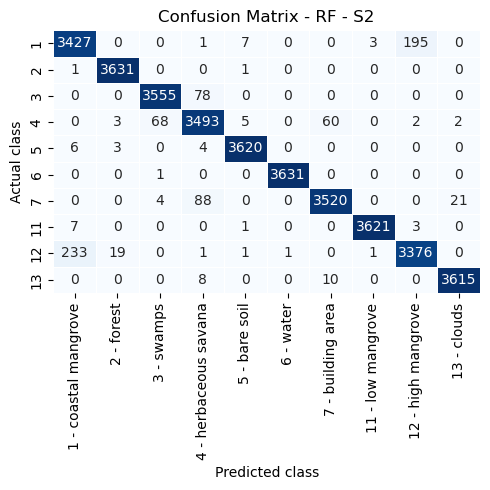

In [206]:
_= evaluate(rf, 
         X_train_s2, 
         X_test_s2, 
         y_train_s2, 
         y_test_s2, 
         label_encoder_s2, 
         labels_mapping=labels_mapping, 
         name="RF - S2"
)

{'accuracy': 0.973655958378066,
 'avg_f1score': 0.9736195559759034,
 'avg_precision': 0.9743056482428119,
 'f1_cls': {1: 0.9342157511581733,
            2: 0.9945160405812997,
            3: 0.9752360103981393,
            4: 0.9491062900805022,
            5: 0.994911291431715,
            6: 0.9997246696035242,
            7: 0.9710836608646827,
            11: 0.9979324603721571,
            12: 0.9261918437679495,
            13: 0.9932775415008919},
 'kappa_score': 0.9707288349750663,
 'precision_cls': {1: 0.8997960224375319,
                   2: 0.9907129199672221,
                   3: 0.969532100108814,
                   4: 0.941017316017316,
                   5: 0.9942275975810885,
                   6: 0.9997246696035242,
                   7: 0.9908335720423948,
                   11: 0.999171956941761,
                   12: 0.9678871548619448,
                   13: 0.9901531728665208}}


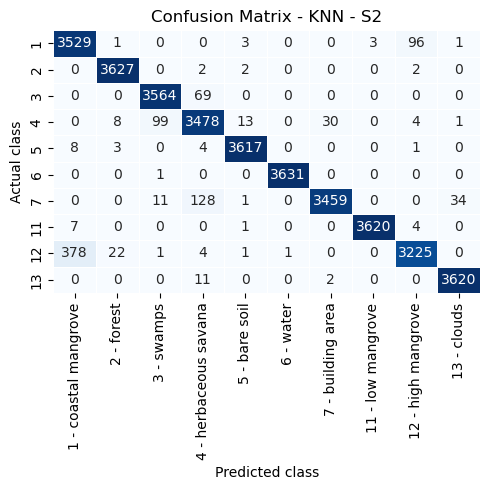

In [207]:
_= evaluate(knn, 
         X_train_s2, 
         X_test_s2, 
         y_train_s2, 
         y_test_s2, 
         label_encoder_s2, 
         labels_mapping=labels_mapping, 
         name="KNN - S2"

)

{'accuracy': 0.9377322652572466,
 'avg_f1score': 0.9370766515368217,
 'avg_precision': 0.9374527705757052,
 'f1_cls': {1: 0.8422367143055363,
            2: 0.9907726208511225,
            3: 0.9272051009564293,
            4: 0.8605194047271667,
            5: 0.9779461507238533,
            6: 0.999587174900234,
            7: 0.9478949562317633,
            11: 0.9752288637587506,
            12: 0.8735314443676573,
            13: 0.9758440845457041},
 'kappa_score': 0.9308136359802017,
 'precision_cls': {1: 0.849188584219362,
                   2: 0.9914553472987873,
                   3: 0.8960205391527599,
                   4: 0.9155541757218255,
                   5: 0.9616817456093667,
                   6: 0.9991746905089408,
                   7: 0.9570707070707071,
                   11: 0.9541622760800843,
                   12: 0.8770469053566472,
                   13: 0.973172734738571}}


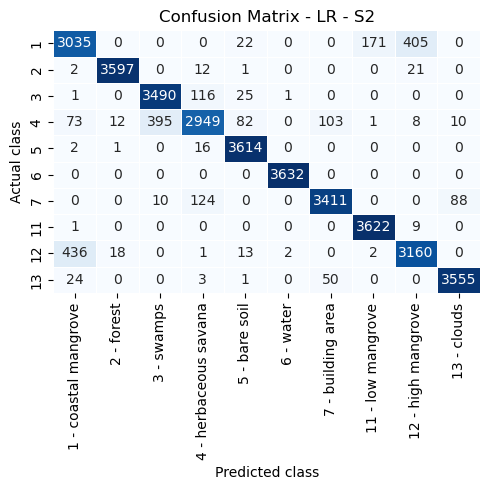

In [208]:
_= evaluate(pipe_lr, 
         X_train_s2, 
         X_test_s2, 
         y_train_s2, 
         y_test_s2, 
         label_encoder_s2, 
         labels_mapping=labels_mapping, 
         name="LR - S2"

)

## S1

{'accuracy': 0.36445939746138556,
 'avg_f1score': 0.3198804765287092,
 'avg_precision': 0.37875539612076525,
 'f1_cls': {1: 0.3318594742342632,
            2: 0.05947084991805198,
            3: 0.19937082186394023,
            4: 0.08495197438633939,
            5: 0.43908875010994813,
            6: 0.9205620102674953,
            7: 0.3435284585780839,
            11: 0.376582579723941,
            12: 0.12350936967632027},
 'kappa_score': 0.28501732738139973,
 'precision_cls': {1: 0.23438564615035204,
                   2: 0.19905956112852666,
                   3: 0.3489332415691672,
                   4: 0.18916349809885932,
                   5: 0.32264736297828334,
                   6: 0.9039533032634651,
                   7: 0.6503067484662577,
                   11: 0.28779281245453225,
                   12: 0.2725563909774436}}


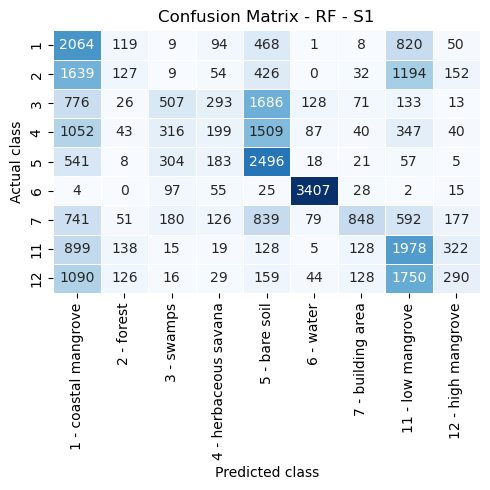

In [209]:
_= evaluate(rf, 
         X_train_s1, 
         X_test_s1, 
         y_train_s1, 
         y_test_s1, 
         label_encoder_s1, 
         labels_mapping=labels_mapping, 
         name="RF - S1"

)

{'accuracy': 0.3252790946627925,
 'avg_f1score': 0.2749305926957547,
 'avg_precision': 0.28919765643033607,
 'f1_cls': {1: 0.2630087583719732,
            2: 0.1402092126995779,
            3: 0.35076730347635454,
            4: 0.1909307875894988,
            5: 0.1524338172502135,
            6: 0.9067206682698393,
            7: 0.002701972439881113,
            11: 0.3859447830763714,
            12: 0.08165803108808291},
 'kappa_score': 0.24094236896961785,
 'precision_cls': {1: 0.24715565238441056,
                   2: 0.21035242290748898,
                   3: 0.28254288597376387,
                   4: 0.1841903300076746,
                   5: 0.3396764985727878,
                   6: 0.8392689784442362,
                   7: 0.07352941176470588,
                   11: 0.26093280325802387,
                   12: 0.16512992455993294}}


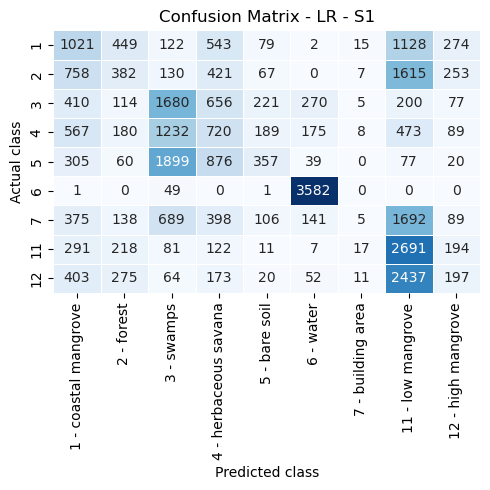

In [211]:
_= evaluate(pipe_lr, 
         X_train_s1, 
         X_test_s1, 
         y_train_s1, 
         y_test_s1, 
         label_encoder_s1, 
         labels_mapping=labels_mapping, 
         name="LR - S1"

)

## S1 & S2

{'accuracy': 0.9761431411530815,
 'avg_f1score': 0.976137731545881,
 'avg_precision': 0.9761627764587512,
 'f1_cls': {1: 0.9400492745688476,
            2: 0.9964315124897063,
            3: 0.9807056229327452,
            4: 0.9575458778416871,
            5: 0.9968358783876737,
            6: 0.9997247453894853,
            7: 0.9774830777731731,
            11: 0.998209119713459,
            12: 0.9382544748161509},
 'kappa_score': 0.9731610320020319,
 'precision_cls': {1: 0.9349305744622924,
                   2: 0.9937038050917054,
                   3: 0.9820590670714877,
                   4: 0.9528481875170346,
                   5: 0.9964246424642464,
                   6: 0.9997247453894853,
                   7: 0.9811425402107599,
                   11: 0.9988971601874828,
                   12: 0.9457342657342658}}


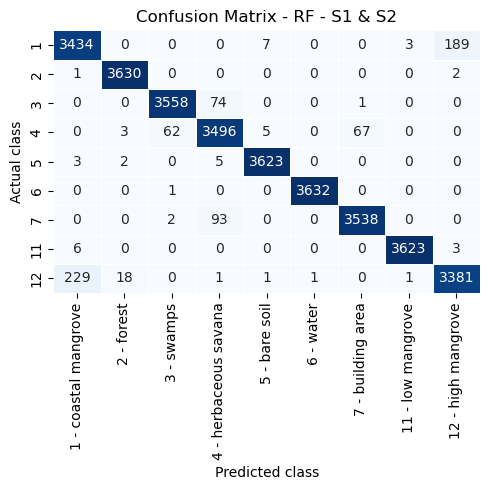

In [210]:
_= evaluate(rf, 
         X_train_s1s2, 
         X_test_s1s2, 
         y_train_s1s2, 
         y_test_s1s2, 
         label_encoder_s1s2, 
         labels_mapping=labels_mapping,
         name="RF - S1 & S2"
)

{'accuracy': 0.9437222816944487,
 'avg_f1score': 0.9432291635244385,
 'avg_precision': 0.9437635452694371,
 'f1_cls': {1: 0.868027956694532,
            2: 0.9914529914529914,
            3: 0.9313686446302932,
            4: 0.8766763848396502,
            5: 0.9859653903801607,
            6: 0.9994496422674739,
            7: 0.9679725085910652,
            11: 0.9837045084193374,
            12: 0.8844444444444445},
 'kappa_score': 0.9366875692013358,
 'precision_cls': {1: 0.8643558951965066,
                   2: 0.9930958298812482,
                   3: 0.8994871794871795,
                   4: 0.9318252246668732,
                   5: 0.9762547220723151,
                   6: 0.9991746905089408,
                   7: 0.9667764964305327,
                   11: 0.9705251875669882,
                   12: 0.8923766816143498}}


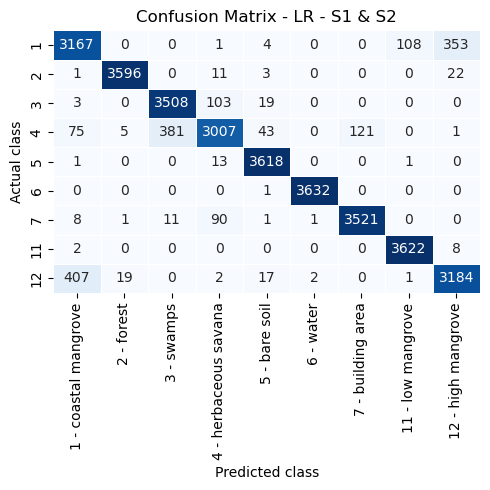

In [212]:
_= evaluate(pipe_lr, 
         X_train_s1s2, 
         X_test_s1s2, 
         y_train_s1s2, 
         y_test_s1s2, 
         label_encoder_s1s2, 
         labels_mapping=labels_mapping,
         name="LR - S1 & S2"
)

### Save

In [435]:
rf = get_train_model(rf, X_train_s2, y_train_s2)
with open(os.path.join(model_dir,"rf_sk_baseline_rsmpl.pkl"), "wb") as fp:
    pickle.dump(rf, fp)

### Ressources

* pixels segmentation with skimage.feature :

https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_trainable_segmentation.html

* pixels classifciation with rggislib :

http://rsgislib.org/rsgislib_classification_classsklearn.html

* plot features importances / impurity :

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances_faces.html

* Quick Unsupervised land cover (kmeans)

https://towardsdatascience.com/unsupervised-land-cover-classification-with-python-8e3734dc3c6d

### Improvement
* LCC Sentinel 1 et 2 workflow
    * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6427458/
    * accuracy enhancement of final classification results is the inclusion of optical indexes of vegetation, soil, water, among others [45,46,47,48]

Sentinel 2 L1C :
* https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/product-types/level-1cm
* coorection sentinel 2 : https://gitlab.orfeo-toolbox.org/orfeotoolbox/otb-documents/-/blob/master/Courses/org/WorkshopGuide/preprocessing-fr.org

## Annexes

#### Filter outiers
```python
df = pd.concat([pd.DataFrame(X, columns=[str(i) for i in range(X.shape[1])]), pd.Series(y, name="label")], axis=1)

cut_off = lambda x: 1.5 * (np.percentile(x, 75) - np.percentile(x, 25))
lower_f = lambda x:  np.percentile(x, 25) - cut_off(x)
upper_f = lambda x:  np.percentile(x, 75) + cut_off(x)

rm_idx = []
for col in df.columns:
    col_values = df[col].values
    lower_value = lower_f(col_values)
    upper_value = upper_f(col_values)
    rm_c = np.where((df[col] < lower_value) | (df[col] > upper_value))[0].tolist()
    rm_idx.extend(rm_c) 
    
rm_idx = list(set(rm_idx))

X = np.delete(X, rm_idx, axis=0)
y= np.delete(y, rm_idx, axis=0)

print(X.shape)
print(y.shape)

pd.Series(y).value_counts()
```

### Show values bandes distribution

In [23]:
df = pd.DataFrame(X_train, columns=[band_mapping[_] for _ in range(X_train.shape[1])])

In [24]:
df.shape

(71775, 10)

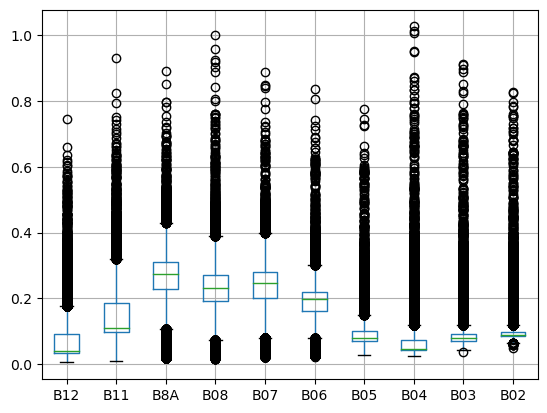

In [27]:
df.boxplot()
plt.show()

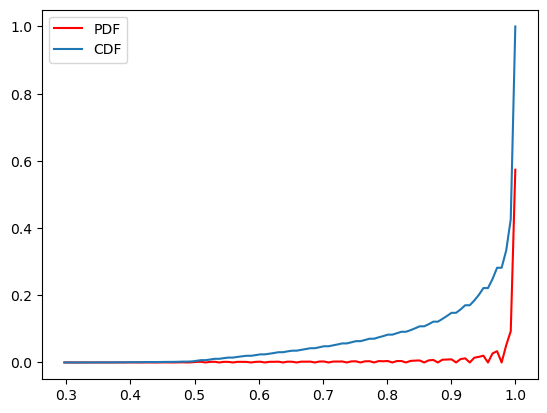

In [485]:
pdf = count / sum(count) 
cdf = np.cumsum(pdf) 
plt.plot(bins_count[1:], pdf, color="red", label="PDF") 
plt.plot(bins_count[1:], cdf, label="CDF") 
plt.legend()

### Analyse des scores de predictions 
* RF

<Axes: xlabel='label', ylabel='score'>

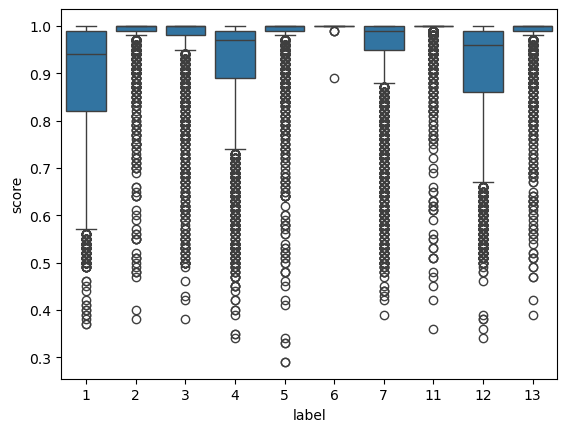

In [476]:
sns.boxplot(data=scores_df, x="label", y="score", orient="x")

#### Fonction de répartition

In [484]:
count, bins_count = np.histogram(scores_df.score, bins=100)

Un classifier plutot "confiant dans sa prédiction"

* On pourrait mettre un score seuil de décision pour "accepter" la prédiction.
* Etudier le modèle multi-label

### OpenCV

In [ ]:
import cv2

In [370]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=Cfg.size_test, 
    stratify=y, 
    random_state=Cfg.seed
)

In [371]:
rtree = cv2.ml.RTrees_create()

In [374]:
rtree.train(X_train, cv2.ml.ROW_SAMPLE, y_train);


In [375]:
_, y_hat = rtree.predict(X_test)


In [377]:
accuracy_score(y_test, y_hat)

0.9081427333358454

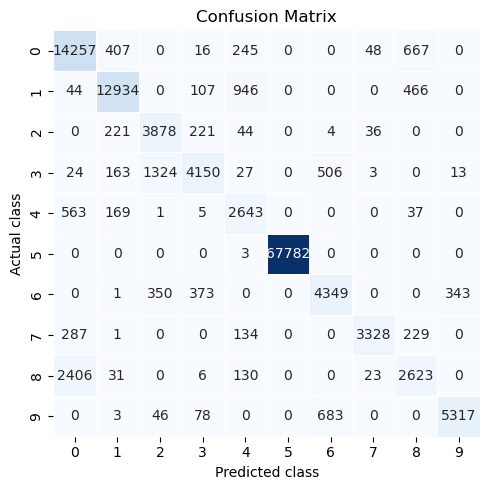

In [343]:
plot_cm(y_test, y_hat, target_names=None)

In [321]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86     15640
           1       0.93      0.89      0.91     14497
           2       0.69      0.88      0.78      4404
           3       0.84      0.67      0.74      6210
           4       0.63      0.77      0.70      3418
           5       1.00      1.00      1.00     67785
           6       0.78      0.80      0.79      5416
           7       0.97      0.84      0.90      3979
           8       0.65      0.50      0.57      5219
           9       0.94      0.87      0.90      6127

    accuracy                           0.91    132695
   macro avg       0.82      0.81      0.81    132695
weighted avg       0.92      0.91      0.91    132695

